# Load image

In [9]:
from preprocess import preprocess_image
import os
import cv2
#Load the model
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
#from skimage.transform import resize
os.chdir("/Users/Thanh/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [5]:
os.chdir("/Users/Thanh/master/Visualization_lab/SAM/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
patient_gt_001 = nib.load("patient001_frame01_gt.nii.gz")
after = preprocess_image(patient_001,spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)
print(after.shape)
after_gt = preprocess_image(patient_gt_001,spacing_target=(10, 1.25, 1.25),is_seg = True, keep_z_spacing=True)
print(after_gt.shape)

(216, 320, 12)
(216, 320, 12)


[1 1 1 ... 2 2 2]


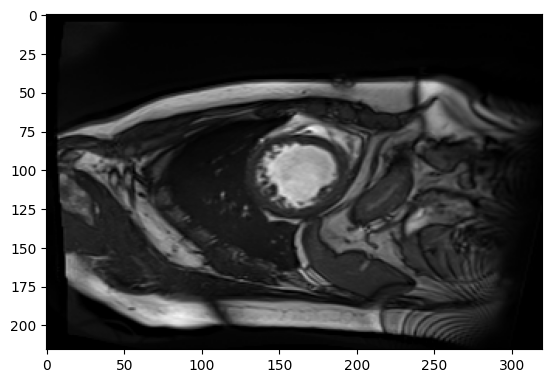

In [10]:
# Convert to RGB
img = cv2.cvtColor(after[:,:,7],cv2.COLOR_GRAY2RGB)
# Change pixel values from [-1,1] to [0,255] range, np.uint8 type because SAM only accepts these values for RGB image
img2 = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img2 = img2.astype(np.uint8)
print(img2[img2>0])
plt.imshow(img2)

In [66]:
import copy
binary = copy.deepcopy(after_gt[:,:,7])
print(np.unique(binary))
int_mask = []
for i in range(1,4):
    int_mask.append(np.where(binary==i,255,0))

[0. 1. 2. 3.]


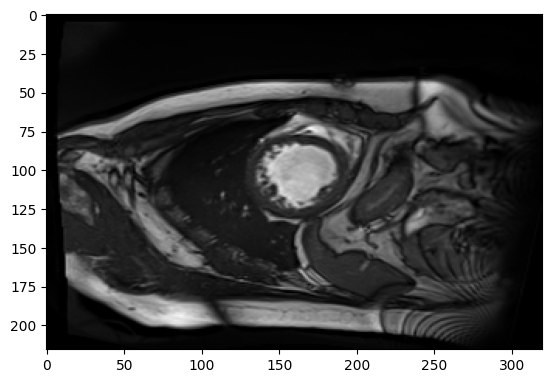

In [37]:
test = cv2.normalize(after[:,:,7], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
test = test.astype(np.uint8)
plt.imshow(test,cmap ="gray")

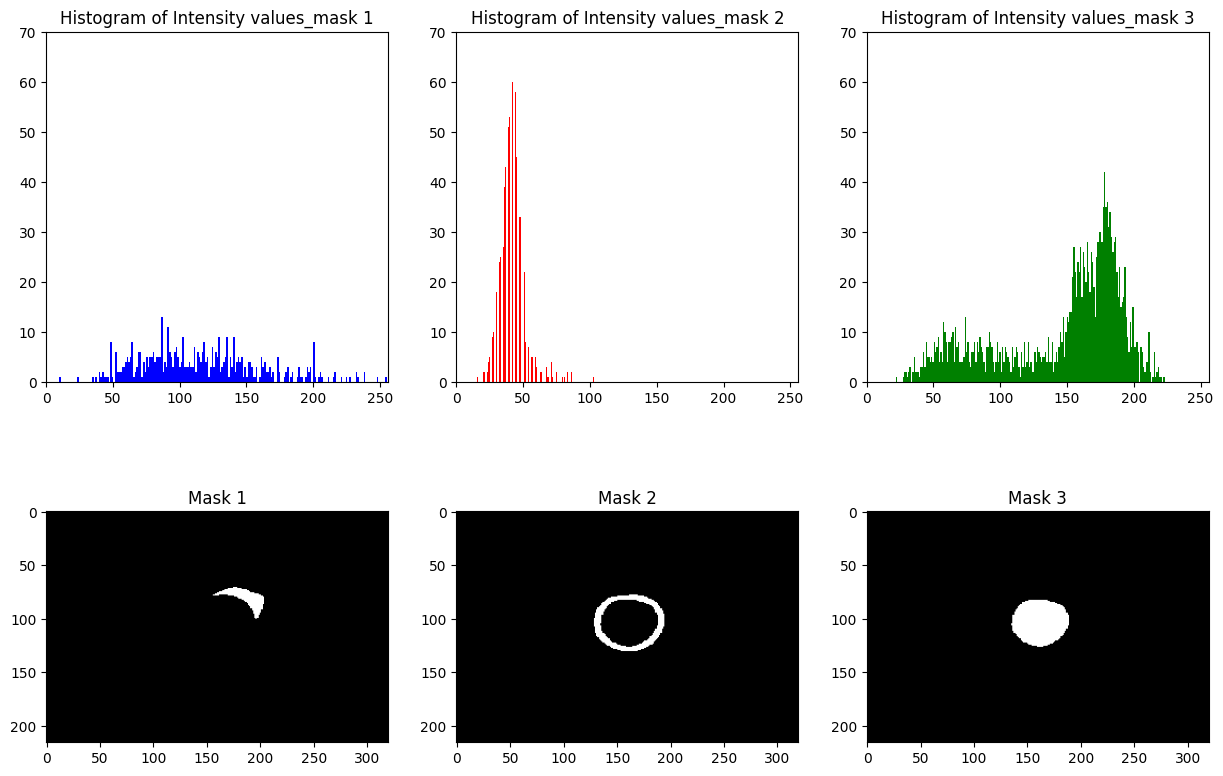

In [69]:
#binary_mask = cv2.bitwise_and(test,test, mask = binary)
#print(binary_mask.shape)
#hist = cv2.calcHist([brain_filter],[0],binary,[256],[0,256])
colors = ['blue','red','green']
fig, ax = plt.subplots(2,3,figsize = (15,10))
for i in range(3):
    ax[0,i].hist(test[int_mask[i]==255], bins=200,log = False,color = colors[i])
    ax[0,i].set_title(f'Histogram of Intensity values_mask {i+1}')
    ax[0,i].set_xlim([0,256])
    ax[0,i].set_ylim([0,70])

    ax[1,i].imshow(int_mask[i],cmap ="gray")
    ax[1,i].set_title(f"Mask {i+1}")
plt.show()

In [34]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)